In [1]:
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor, KernelDensity, NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

from sklearn.metrics import silhouette_score, davies_bouldin_score

from umap import UMAP
from sklearn.manifold import TSNE

from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import prediction_strength_CV

from utils import coord_to_pix, entropy, swap_columns

c_s = ['g__Anabaena', 'g__Candidatus_Planktophila', 'g__Dolichospermum']
PERC_THRESH = 70

# Load data

In [2]:
DATA_SPECIFICATION = 'data_processed_small' #'_pat0.7'

datasets_names = ['Conest']
tax_names = ['g']

data_orig = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        dataframe = pd.read_csv(f'./data_processed_small/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1)
    
data_pca = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 314.77it/s]


In [ ]:
# %matplotlib inline
# CLUSTERING = False

# for dataset_name in ['AGP', 'HMP']:
#     label = dataset_name + '_g'

#     data_3d_cs = data_orig[label][c_s].values 
    
#     fig = plt.figure(figsize=(10,10), dpi=300)
#     ax = plt.axes(projection="3d")

#     if CLUSTERING:
        
#         y_enterotypes = np.load(f'./data_processed{DATA_SPECIFICATION}/enterotypes_clf.npy', allow_pickle=True).item()
#         preprocessing_mask = np.load(f'./data_processed{DATA_SPECIFICATION}/preprocessing_mask.npy', allow_pickle=True).item()

#         y = y_enterotypes[dataset_name].astype(int)
#         mask_ = y != -1

#         X = data_3d_cs[mask_]
#         labels = y[mask_]

#         dbind = davies_bouldin_score(X, labels)
#         silh = silhouette_score(X, labels)
#         dbcv = DBCV(X, labels, d=data_orig[label].shape[1])
#         ps = prediction_strength_CV(X, y=labels)

#         # data mass distribution
#         n = len(np.unique(labels))
#         cl_dist = np.ones(n)
#         for i in range(n):
#             cl_dist[i] = sum(labels == i)/len(labels)

#         ent = entropy(cl_dist)

#         uncl_ratio = (1 - (mask_.sum() / len(mask_)))*100


#         ax.scatter3D(data_3d_cs[:,0][mask_], 
#                      data_3d_cs[:,1][mask_], 
#                      data_3d_cs[:,2][mask_],
#                      c=y[mask_],
#                      edgecolor='black',
#                      alpha=0.5)

#         handles, labels = plt.gca().get_legend_handles_labels()

#         text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
#         handles.append(text_handle)

#         text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
#         handles.append(text_handle)

#         text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
#         handles.append(text_handle)

#         text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
#         handles.append(text_handle)

#         text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
#         handles.append(text_handle)

#         text_handle = mlines.Line2D([], [], color='none', label='Unclassified %: {:.2f}'.format(uncl_ratio))
#         handles.append(text_handle)

#         # Add the arbitrary information patch to the legend handles
#         legend = plt.legend(handles=handles, 
#                             loc=(0.45,0.6), 
#                             fontsize=20, 
#                             frameon=True, 
#                             fancybox=True, 
#                             framealpha=0.0)

#     else:

#         ax.scatter3D(data_3d_cs[:,0], 
#                      data_3d_cs[:,1], 
#                      data_3d_cs[:,2],
#                      color='maroon' if dataset_name == 'AGP' else 'steelblue',
#                      edgecolor='black',
#                      alpha=0.5)

#     plt.title(f"{dataset_name}, tax: G", fontsize=30)

#     ax.set_zticklabels([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

#     ax.view_init(elev=None, azim=40)


#     ax.set_xlabel('Bacteroides', fontsize=30)
#     ax.set_ylabel('Prevotella', fontsize=30)
#     ax.set_zlabel('Ruminococcus', fontsize=30)

#     ax.set_xlim(data_3d_cs[:,0].min(), data_3d_cs[:,0].max())
#     ax.set_ylim(data_3d_cs[:,1].min(), data_3d_cs[:,1].max())
#     ax.set_zlim(data_3d_cs[:,2].min(), data_3d_cs[:,2].max())

#     ax.grid(True)
#     plt.show()

In [3]:
results_path = f'./results/vis_sep{DATA_SPECIFICATION}.npy'

if os.path.exists(results_path):

    results = np.load(results_path, allow_pickle=True).item()
    Z_umap = results['umap']
    Z_tsne = results['tsne']
    densities_umap = results['umap_dens']
    densities_tsne = results['tsne_dens']
    
else:
    
    Z_umap = {}
    Z_tsne = {}
    
    densities_umap = {}
    densities_tsne = {}
    
    for label, X in tqdm(data_pca.items()):
        Z_umap[label] = UMAP(n_components=2, 
                             n_neighbors=15,
                             n_jobs=-1, 
                             spread=0.7, 
                             random_state=42).fit_transform(X)
        
        Z_tsne[label] = TSNE(n_components=2, 
                             early_exaggeration=6, 
                             random_state=42, 
                             n_jobs=-1).fit_transform(X)

  0%|                                                                                                                | 0/1 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/leydenfernandez/anaconda3/envs/microbiome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/leydenfernandez/anaconda3/envs/microbiome/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


# UMAP 2D: Visualize

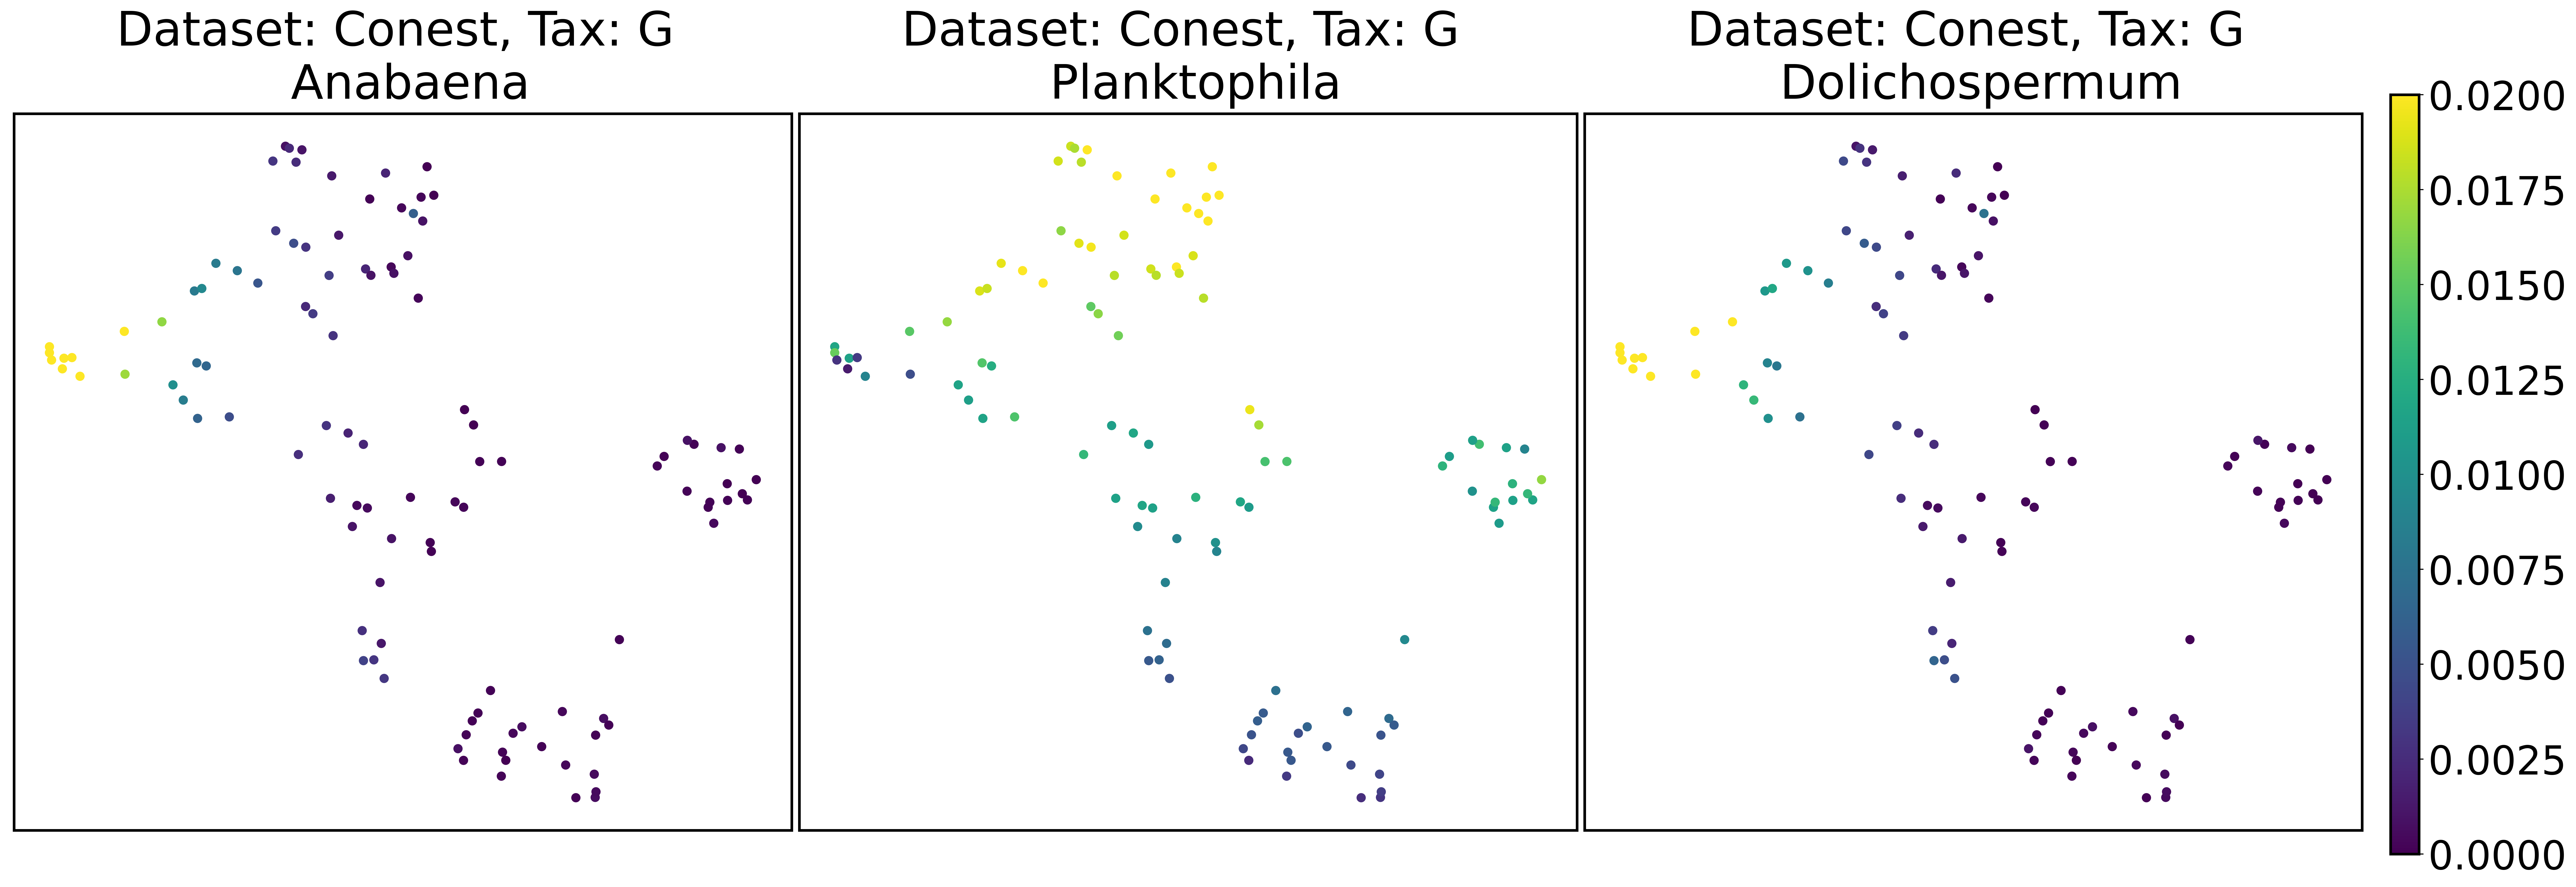

In [9]:
from matplotlib.colors import Normalize
use_lof = True
Z_lof_umap = {}
Z_lof_umap_mask = {}

for label, Z in Z_umap.items():
    #label = dataset_name + '_g'
    datasets_names = ['Conest']
    dataset, tax = label.split('_')
    X_orig = data_orig[dataset + '_' + tax]
    
    plt.rcParams.update({'font.size': 30, 
                         'axes.titley':1.01, 
                         'axes.linewidth':2,
                         'font.weight':'normal'})
    
    fig, axes = plt.subplots(ncols=len(c_s), nrows=1, figsize=(30,10), dpi=400, sharex=True, sharey=True)
    
    if use_lof:
        lof_mask = LocalOutlierFactor(n_neighbors=70).fit_predict(Z) != -1
        
    else:
        lof_mask = np.ones((Z.shape[0],),dtype=bool)
    Z_lof_umap[label] = Z[lof_mask]
    Z_lof_umap_mask[label] = lof_mask
    
    for i,c_i in enumerate(c_s):
        

# Modify the scatter line:
        norm = Normalize(vmin=0, vmax=0.02) 
        mp = axes[i].scatter(Z[:,0][lof_mask], Z[:,1][lof_mask], c=X_orig[c_i][lof_mask], norm=norm)
        c_name = c_i.split('_')[-1]
        axes[i].set_title(f'Dataset: {dataset}, Tax: {tax.capitalize()} \n {c_name}', alpha=1)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    fig.subplots_adjust(right=0.95,
                        wspace=0.01, 
                        hspace=0.001)
    cbar_ax = fig.add_axes([0.96, 0.1, 0.01, 0.8]) # l,b,w,h
    fig.colorbar(mp, cax=cbar_ax)
plt.show()

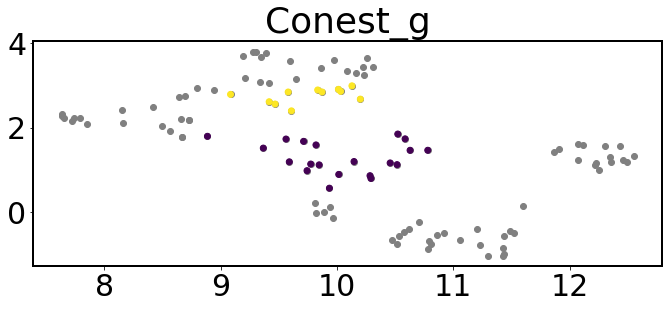

In [5]:
# calculate densities
RES = 50

#fig, axes = plt.subplots(ncols=len(Z_lof_umap), nrows=1, figsize=(10,5))
fig, axes = plt.subplots(ncols=len(Z_lof_umap), nrows=1, figsize=(10,5))

if len(Z_lof_umap) == 1:
    axes = [axes]


y_hd_dict_umap = {}
X_hd_dict_umap = {}
hd_mask_dict_umap = {}

for i,(label, Z) in enumerate(Z_lof_umap.items()):

    nneigh = NearestNeighbors(n_neighbors=100)
    nneigh.fit(Z)
    D,_ = nneigh.kneighbors(Z)
    bandwidth = np.median(D.flatten())

    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(Z)

    x_grid = np.linspace(Z[:,0].min(), Z[:,0].max(), num=RES)
    y_grid = np.linspace(Z[:,1].min(), Z[:,1].max(), num=RES)
    XX = np.stack(np.meshgrid(x_grid, y_grid),axis=-1).reshape(RES**2,-1)

    XX_likelihood = kde.score_samples(XX)
    XX_likelihood = XX_likelihood.reshape(RES,RES)

    densities_umap[label] = np.exp(XX_likelihood)[::-1,:]
    
    data_scores = kde.score_samples(Z)
    X_orig_lof = data_orig[label][Z_lof_umap_mask[label]]
    data_density = np.exp(data_scores)
    
    # select high-density regions
    high_density_mask = data_density > np.percentile(data_density, q=PERC_THRESH)
    X_orig_lof_hd = X_orig_lof[high_density_mask]
    Z_hd = Z[high_density_mask]
    
    # highlight clusters
    hdbscan_params = {'Conest_g':{'min_cluster_size':3}}
    y_hd = HDBSCAN(**hdbscan_params[label]).fit_predict(Z_hd) 
    
    y_hd_dict_umap[label] = y_hd
    X_hd_dict_umap[label] = X_orig_lof_hd
    hd_mask_dict_umap[label] = high_density_mask
    
    ax = axes[i]
    ax.scatter(Z[:,0], Z[:,1], color='grey')
    ax.scatter(Z_hd[:,0][y_hd!=-1],Z_hd[:,1][y_hd!=-1],c=y_hd[y_hd!=-1])
    ax.scatter(Z_hd[:,0][y_hd==-1],Z_hd[:,1][y_hd==-1],color='grey')
    ax.set_title(label)
    
plt.tight_layout()
plt.show()

In [6]:
def make_name(c):
    name = c.split('__')[1]
    #if name == '1-68':
        #return 'Tissierellaceae'
    #if name=='WAL_1855D':
        #return 'Sporobacterium'
    return name if len(name) > 0 else 'Rest.'

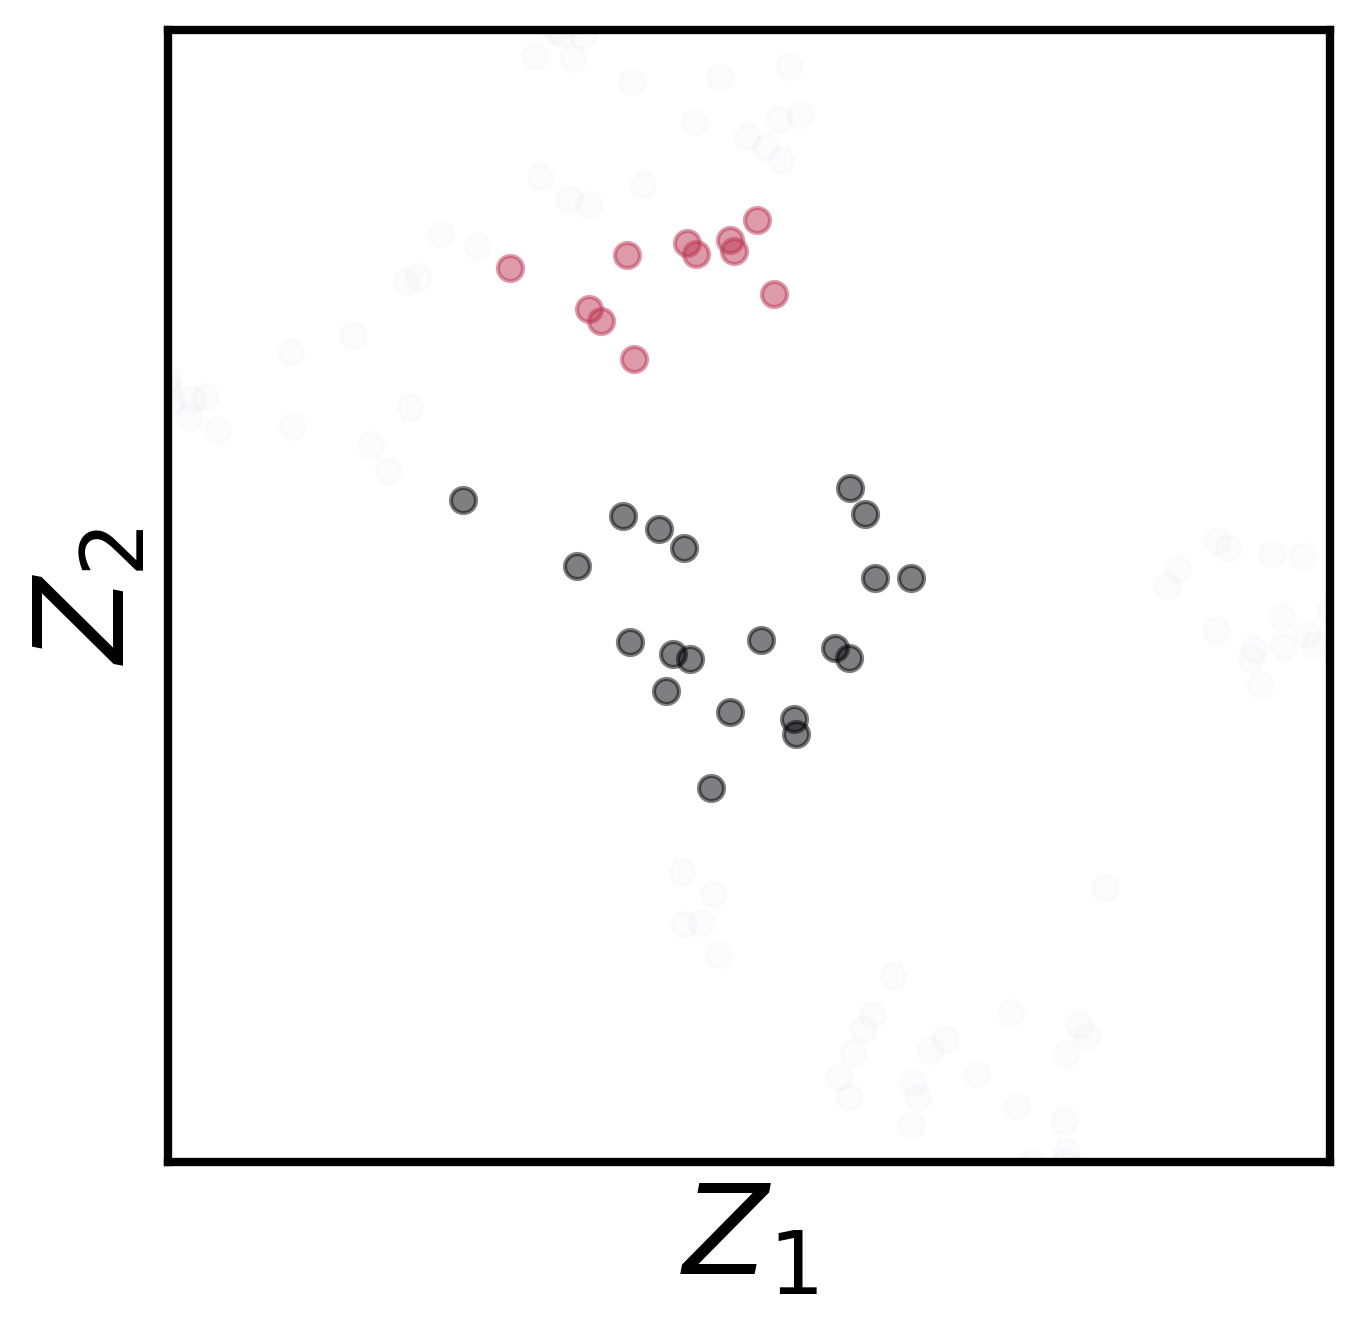

In [7]:
import matplotlib.cm as cm
basecolor = cm.viridis.colors[0]
for i,(label, Z) in enumerate(Z_lof_umap.items()):


    plt.figure(figsize=(5,5),dpi=300)

    #basecolor=mpl.colormaps['viridis'].colors[0]

    plt.rcParams['axes.linewidth'] = 2

    pix_0 = coord_to_pix(Z[:,0], n_pix=RES)
    pix_1 = coord_to_pix(Z[:,1], n_pix=RES)

    high_density_mask = hd_mask_dict_umap[label]
    y_hd = y_hd_dict_umap[label]
    N_CLUST = len(np.unique(y_hd[y_hd!=-1])) 
    
    plt.scatter(pix_0[~high_density_mask],pix_1[~high_density_mask],
                alpha=0.01,
                color=basecolor
               )
    

    for y_k in np.arange(N_CLUST):

        c_k = int(256*(y_k/N_CLUST))
        #color=mpl.colormaps['inferno'].colors[c_k]
        color = cm.inferno.colors[c_k]
        y_mask = y_hd==y_k

        plt.scatter(pix_0[high_density_mask][y_mask], pix_1[high_density_mask][y_mask],
                    alpha=0.5, color=color
                   )


    plt.xlim(0, RES)
    plt.ylim(0, RES)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel(r'$Z_1$',fontsize=30)
    plt.ylabel(r'$Z_2$',fontsize=30)

    plt.show()

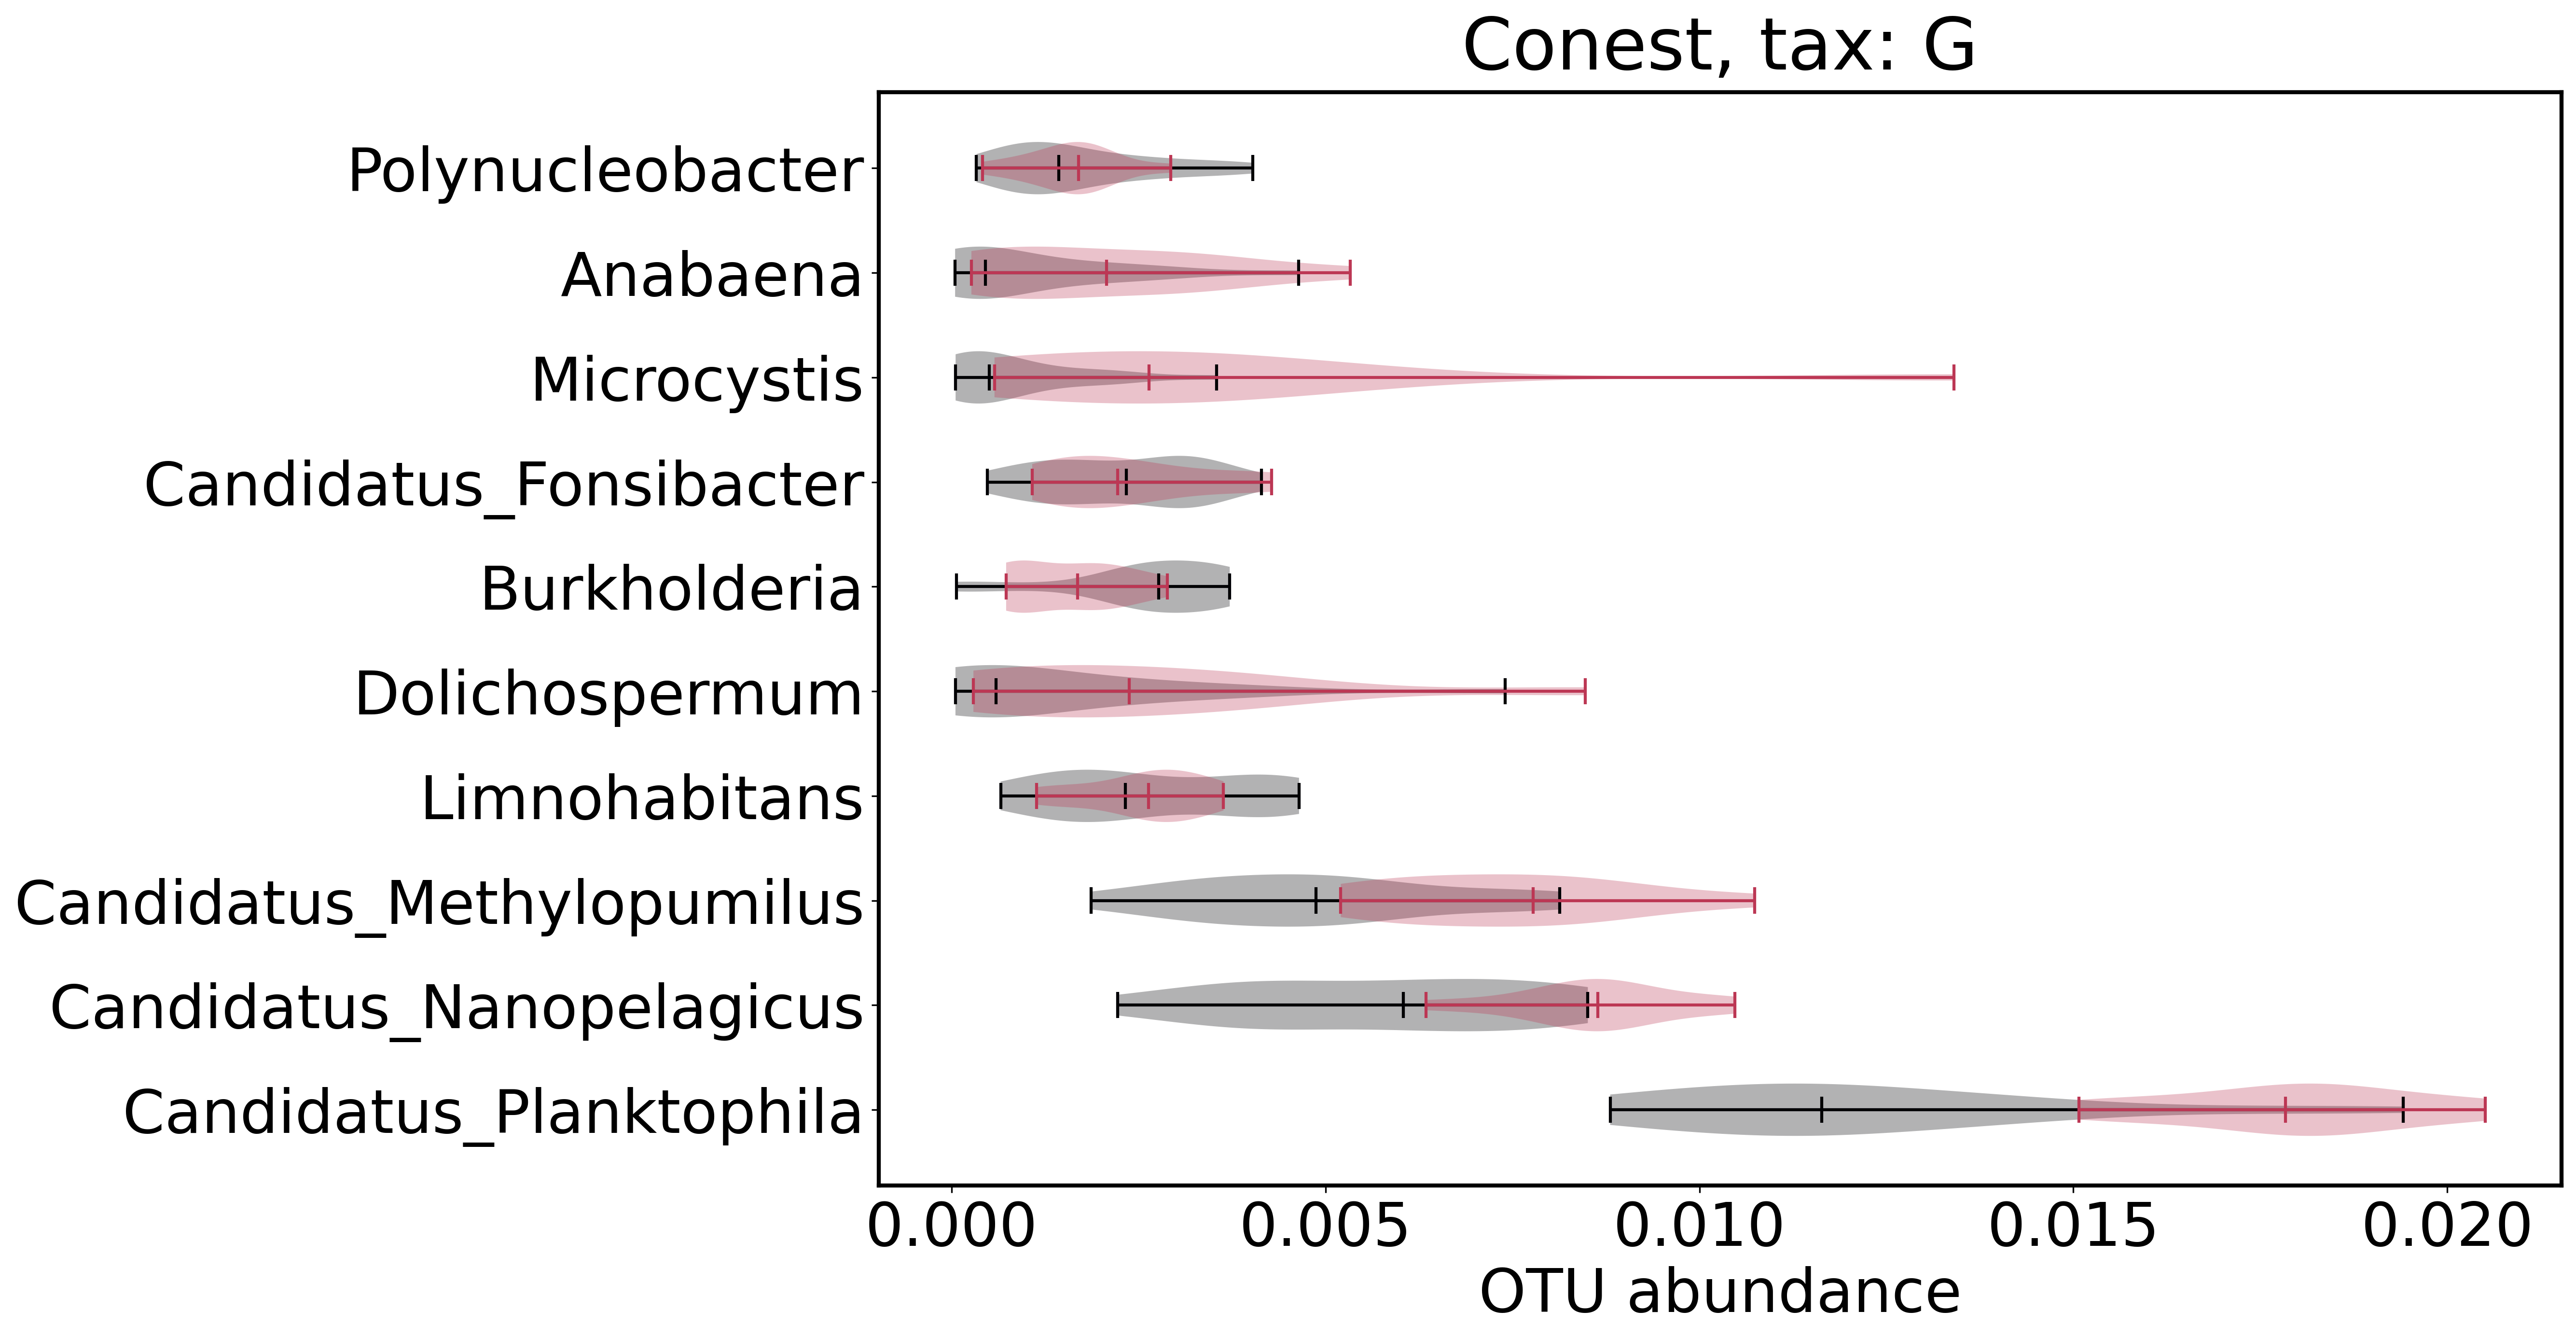

In [8]:

for i,(label, X_orig_lof_hd) in enumerate(X_hd_dict_umap.items()):
    

    plt.rcParams.update({'font.size': 30, 'axes.titley':1.01, 'font.weight':'normal'})

    dataset_name, tax_name = label.split('_')

    col_names_hd = list(X_orig_lof_hd.mean(0).sort_values(ascending=False)[:10].index)

    y_hd = y_hd_dict_umap[label]
    N_CLUST = len(np.unique(y_hd[y_hd!=-1])) 

    for k,c_k in enumerate(c_s): 
        if not c_k in col_names_hd:
            col_names_hd.pop(-k)
            col_names_hd.insert(1, c_k)

    names = [make_name(c_s) for c_s in col_names_hd]

    plt.figure(figsize=(15,10),dpi=300)

    for y_k in np.arange(N_CLUST):

        c_k = int(256*(y_k/N_CLUST))
        #color=mpl.colormaps['inferno'].colors[c_k]
        color = cm.inferno.colors[c_k]

        X_orig_lof_hd_k = X_orig_lof_hd[y_hd==y_k][col_names_hd]

        #X_orig_lof_hd_k = swap_columns(X_orig_lof_hd_k, 'g__Faecalibacterium', 'g__Ruminococcus')
        names = [make_name(c) for c in X_orig_lof_hd_k.columns]

        violin_parts = plt.violinplot(X_orig_lof_hd_k, vert=False, showmedians=True)

        for k,v in violin_parts.items():

            if isinstance(v ,list):
                for vp_body in v:
                    vp_body.set_facecolors(color) 
            else:
                v.set_color(color)


    plt.yticks(np.arange(1,len(col_names_hd)+1), names, fontsize=30)

    plt.xlabel('OTU abundance')
    plt.title(dataset_name + f', tax: {tax_name.capitalize()}')

    plt.show()
    

In [ ]:
fig, axes = plt.subplots(ncols=len(densities_umap), nrows=1, figsize=(20,10), dpi=400, sharex=True, sharey=True)

plt.rcParams.update({'font.size': 30, 'axes.titley':1.01, 'font.weight':'normal'})

for i,(label, density) in enumerate(densities_umap.items()):
    
    dataset, tax = label.split('_')
    mp = axes[i].imshow(density, cmap='magma')
    density_perc = np.percentile(density.flatten(), PERC_THRESH)
    density_mask = density > density_perc
    density_levels = density
    
    x = np.linspace(0, density.shape[1], density.shape[1])
    y = np.linspace(0, density.shape[0], density.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = density_levels 
    
    axes[i].contour(X, Y, Z, colors='white', linewidths=2, levels=10, alpha=0.5)
    axes[i].set_title(f'Dataset: {dataset}, Tax: {tax.capitalize()}', alpha=1, fontsize=30)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.subplots_adjust(right=0.95,
                    wspace=0.01, 
                    hspace=0.01)
cbar_ax = fig.add_axes([0.96, 0.1, 0.01, 0.8]) # l,b,w,h

# Create a colorbar
cbar = fig.colorbar(mp, cax=cbar_ax)

# Define a custom formatter for colorbar values
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')  # Format to two decimal places

# Set the formatter for the colorbar
cbar.ax.yaxis.set_major_formatter(formatter)
plt.show()

# t-SNE 2D

In [ ]:
use_lof = True
Z_lof_tsne = {}
Z_lof_tsne_mask = {}
for label, Z in Z_tsne.items():
    
    dataset, tax = label.split('_')
    X_orig = data_orig[dataset + '_' + tax]
    
    plt.rcParams.update({'font.size': 30, 
                         'axes.titley':1.01, 
                         'axes.linewidth':2,
                         'font.weight':'normal'})
    
    fig, axes = plt.subplots(ncols=len(c_s), nrows=1, figsize=(30,10), dpi=400, sharex=True, sharey=True)
    
    if use_lof:
        lof_mask = LocalOutlierFactor(n_neighbors=50).fit_predict(Z) != -1
    else:
        lof_mask = np.ones((Z.shape[0],),dtype=bool)
    Z_lof_tsne[label] = Z[lof_mask]
    Z_lof_tsne_mask[label] = lof_mask
    
    for i,c_i in enumerate(c_s):
        mp = axes[i].scatter(Z[:,0][lof_mask], Z[:,1][lof_mask], c=X_orig[c_i][lof_mask])
        c_name = c_i.split('_')[-1]
        axes[i].set_title(f'Dataset: {dataset}, Tax: {tax.capitalize()} \n {c_name}', alpha=1)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    fig.subplots_adjust(right=0.95,
                        wspace=0.01, 
                        hspace=0.01)
    cbar_ax = fig.add_axes([0.96, 0.1, 0.01, 0.8]) # l,b,w,h
    fig.colorbar(mp, cax=cbar_ax)
plt.show()

In [ ]:
# calculate densities
RES = 250

fig, axes = plt.subplots(ncols=len(Z_lof_tsne), nrows=1, figsize=(10,5))

y_hd_dict_tsne = {}
X_hd_dict_tsne = {}
hd_mask_dict_tsne = {}

for i,(label, Z) in enumerate(Z_lof_tsne.items()):

    nneigh = NearestNeighbors(n_neighbors=100)
    nneigh.fit(Z)
    D,_ = nneigh.kneighbors(Z)
    bandwidth = np.median(D.flatten())

    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(Z)

    x_grid = np.linspace(Z[:,0].min(), Z[:,0].max(), num=RES)
    y_grid = np.linspace(Z[:,1].min(), Z[:,1].max(), num=RES)
    XX = np.stack(np.meshgrid(x_grid, y_grid),axis=-1).reshape(RES**2,-1)

    XX_likelihood = kde.score_samples(XX)
    XX_likelihood = XX_likelihood.reshape(RES,RES)

    densities_tsne[label] = np.exp(XX_likelihood)[::-1,:]
    
    data_scores = kde.score_samples(Z)
    X_orig_lof = data_orig[label][Z_lof_tsne_mask[label]]
    data_density = np.exp(data_scores)
    
    # select high-density regions
    high_density_mask = data_density > np.percentile(data_density, q=PERC_THRESH)
    X_orig_lof_hd = X_orig_lof[high_density_mask]
    Z_hd = Z[high_density_mask]
    
    # highlight clusters
    hdbscan_params = {'AGP_g':{'min_cluster_size':20,
                                 'cluster_selection_epsilon':12.4}, 
                        'HMP_g':{'min_cluster_size':10,
                                 'cluster_selection_epsilon':8}}
    y_hd = HDBSCAN(**hdbscan_params[label]).fit_predict(Z_hd)   
    
    y_hd_dict_tsne[label] = y_hd
    X_hd_dict_tsne[label] = X_orig_lof_hd
    hd_mask_dict_tsne[label] = high_density_mask
    
    ax = axes[i]
    ax.scatter(Z[:,0], Z[:,1], color='grey')
    ax.scatter(Z_hd[:,0][y_hd!=-1],Z_hd[:,1][y_hd!=-1],c=y_hd[y_hd!=-1])
    ax.scatter(Z_hd[:,0][y_hd==-1],Z_hd[:,1][y_hd==-1],color='grey')
    ax.set_title(label)
    
plt.tight_layout()
plt.show()

In [ ]:
for i,(label, Z) in enumerate(Z_lof_tsne.items()):


    plt.figure(figsize=(5,5),dpi=300)

    basecolor=mpl.colormaps['viridis'].colors[0]

    plt.rcParams['axes.linewidth'] = 2

    pix_0 = coord_to_pix(Z[:,0], n_pix=RES)
    pix_1 = coord_to_pix(Z[:,1], n_pix=RES)

    high_density_mask = hd_mask_dict_tsne[label]
    y_hd = y_hd_dict_tsne[label]
    N_CLUST = len(np.unique(y_hd[y_hd!=-1])) 
    
    plt.scatter(pix_0[~high_density_mask],pix_1[~high_density_mask],
                alpha=0.01,
                color=basecolor
               )
    

    for y_k in np.arange(N_CLUST):

        c_k = int(256*(y_k/N_CLUST))
        color=mpl.colormaps['inferno'].colors[c_k]

        y_mask = y_hd==y_k

        plt.scatter(pix_0[high_density_mask][y_mask], pix_1[high_density_mask][y_mask],
                    alpha=0.5, color=color
                   )


    plt.xlim(0, RES)
    plt.ylim(0, RES)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel(r'$Z_1$',fontsize=30)
    plt.ylabel(r'$Z_2$',fontsize=30)

    plt.show()

In [ ]:

for i,(label, X_orig_lof_hd) in enumerate(X_hd_dict_tsne.items()):
    

    plt.rcParams.update({'font.size': 30, 'axes.titley':1.01, 'font.weight':'normal'})

    dataset_name, tax_name = label.split('_')

    col_names_hd = list(X_orig_lof_hd.mean(0).sort_values(ascending=False)[:10].index)

    y_hd = y_hd_dict_tsne[label]
    N_CLUST = len(np.unique(y_hd[y_hd!=-1])) 

    for k,c_k in enumerate(c_s): 
        if not c_k in col_names_hd:
            col_names_hd.pop(-k)
            col_names_hd.insert(1, c_k)

    names = [make_name(c) for c in col_names_hd]

    plt.figure(figsize=(15,10),dpi=300)

    for y_k in np.arange(N_CLUST):

        c_k = int(256*(y_k/N_CLUST))
        color=mpl.colormaps['inferno'].colors[c_k]

        X_orig_lof_hd_k = X_orig_lof_hd[y_hd==y_k][col_names_hd]

        X_orig_lof_hd_k = swap_columns(X_orig_lof_hd_k, 'g__Faecalibacterium', 'g__Ruminococcus')
        names = [make_name(c) for c in X_orig_lof_hd_k.columns]

        violin_parts = plt.violinplot(X_orig_lof_hd_k, vert=False, showmedians=True)

        for k,v in violin_parts.items():

            if isinstance(v ,list):
                for vp_body in v:
                    vp_body.set_facecolors(color) 
            else:
                v.set_color(color)


    plt.yticks(np.arange(1,len(col_names_hd)+1), names, fontsize=30)

    plt.xlabel('OTU abundance')
    plt.title(dataset_name + f', tax: {tax_name.capitalize()}')

    plt.show()
    

In [ ]:
fig, axes = plt.subplots(ncols=len(densities_tsne), nrows=1, figsize=(20,10), dpi=400, sharex=True, sharey=True)

for i,(label, density) in enumerate(densities_tsne.items()):
    
    dataset, tax = label.split('_')
    mp = axes[i].imshow(density, cmap='magma')
    density_perc = np.percentile(density.flatten(), 70)
    density_mask = density > density_perc
    density_levels = density
    
    x = np.linspace(0, density.shape[1], density.shape[1])
    y = np.linspace(0, density.shape[0], density.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = density_levels 
    
    axes[i].contour(X, Y, Z, colors='white', linewidths=2, levels=10, alpha=0.5)
    axes[i].set_title(f'Dataset: {dataset}, Tax: {tax.capitalize()}', alpha=1, fontsize=30)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.subplots_adjust(right=0.95,
                    wspace=0.01, 
                    hspace=0.01)
cbar_ax = fig.add_axes([0.96, 0.1, 0.01, 0.8]) # l,b,w,h

# Create a colorbar
cbar = fig.colorbar(mp, cax=cbar_ax)

# fmt = lambda x, pos: f'{x:.10f}'
fmt = lambda x, pos: f'{x:.1e}'

# Define a custom formatter for colorbar values
formatter = ticker.FuncFormatter(fmt)  # Format to two decimal places

# Set the formatter for the colorbar
cbar.ax.yaxis.set_major_formatter(formatter)
plt.show()

In [ ]:
if not os.path.exists(results_path):

    vis_res = {'umap':Z_umap,
               'umap_lof':Z_lof_umap,
               'umap_lof_mask':Z_lof_umap_mask,
               'umap_dens':densities_umap,
               'tsne':Z_tsne,
               'tsne_lof':Z_lof_tsne,
               'tsne_lof_mask':Z_lof_tsne_mask,
               'tsne_dens':densities_tsne}

    np.save(results_path, vis_res)